# Градиентный бустинг

С помощью алгоритма градиентного бустинга можно оптимизировать произвольные дифференцируемые функции потерь.

В приведенном ниже классе `GradientBoostingCustom`:
* `objective` &ndash; функция потерь, $L(y, f)$;
* `objective_grad` &ndash; градиент функции потерь, $\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}$;
* `n_estimators` &ndash; число итераций алгоритма;
* `DesicionTreeRegressor` &ndash; базовый алгоритм (дерево решений) $b(x,\theta)$, где $\theta$ &ndash; гиперпараметры;
* `learning_rate` &ndash; коэффициент, с которым $b_t(x,\theta)$ входит в композицию, $\eta_t$.

В реализации необходимо:
* инициализировать базовый алгоритм средним значением вектора $y$, то есть $\hat{f_0}={1\over{y}}\sum_{i=1}^l y_i$;
* задать постоянный шаг градиентного спуска $\eta_t=const$.

# Реализация алгоритма

In [84]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
%matplotlib inline

Класс `GradientBoostingCustom` принимает параметры:
- `loss` &ndash; имя функции потерь;
- `n_estimators` &ndash; число деревьев;
- `learning_rate` &ndash; шаг градиентного спуска;
- `max_depth` &ndash; ограничение на максимальную глубину деревьев;
- `random_state`.

В зависимости от переданного значения `loss` инициализируются:
- `objective`;
- `objective_grad`.

Для MSE используется `sklearn.mean_squared_error`, для log_loss &ndash; `sklearn.metrics.log_loss`.

RMSLE и poisson нужно реализовать самостоятельно. В реализациях градиентов будет покомпонентное деление на вектора. Чтобы избежать деления на 0, предварительно заменим значения меньше $10^{-5}$ на $10^{-5}$, где это необходимо.

Класс имеет методы `fit`, `predict` и `predict_proba`:
- `fit` принимает матрицу `X` и вектор `y` (`numpy.array`). На каждой итерации текущее значение функции потерь записывается в `loss_by_iter_`, значение антиградиента &ndash; в `residuals`. Обученное дерево добавляется в список `trees`;
- `predict_proba` возвращает линейную комбинацию прогнозов деревьев. В случае классификации к ответу применяется сигмоида. В реализации сигмоиды замените значения аргумента, превышающие по модулю 100, на -100 или +100;
- `predict` в случае регрессии возвращает линейную комбинацию прогнозов деревьев (то же, что и `predict_proba`). В случае классификации метод `predict` задействует метод `predict_proba` и возвращает вектор из 0 и 1, полученный сравнением предсказанных вероятностей с некоторым порогом, при котором максимизируется доля правильных ответов на обучающей выборке.

In [93]:
class GradientBoostingCustom(BaseEstimator):
    
    def sigma(self, z):
        # возвращает предсказания вероятностей в задаче классификации, размерность на выходе (len(z), 1) (!!!)
        # чтобы не возникало проблем с делением на 0, ограничьте z сверху и снизу
        z = z.reshape([z.shape[0],1])
        z[z>100] = 100
        z[z<-100] = 100
        return 1. / (1+np.exp(-z))
        
    
    def log_loss_grad(self, y, p):
        # возвращает градиент функции потерь для задачи классификации, (len(z), 1)
        y = y.reshape([y.shape[0],1])
        p = p.reshape([p.shape[0],1])
        return (p - y) / p / (1 -p)
    
    def mse_grad(self, y, p):
        # возвращает градиент функции потерь для задачи регрессии, (len(z), 1)
        return 2*(p-y.reshape([y.shape[0],1])) / y.shape[0]
    
    def rmsle(self, y, p):
        # возвращает значение RMSLE для задачи регрессии, (len(z), 1)
        y = y.reshape([y.shape[0],1])
        p = p.reshape([p.shape[0],1])        
        return np.sqrt(np.mean(np.log(y + 1) - np.log((p+1)**2)))
    
    def rmsle_grad(self, y, p):
        # возвращает градиент функции потерь RMSLE для задачи регрессии, (len(z), 1)
        y = y.reshape([y.shape[0],1])
        p = p.reshape([p.shape[0],1])
        return 1. / self.rmsle(y, p) * np.log((y+1)/(p+1)) / (p+1) #дописать
    
                                               
    def poisson(self, y, p):
        # возвращает значение функции потерь пуассоновской регрессии, (len(z), 1)
        return np.mean(y*p - np.exp(p))
    
    def poisson_grad(self, y, p):
        # возвращает градиент функции потерь пуассоновской регрессии, (len(z), 1)
        return (y - np.exp(p))/y.shape[0]
    
    def __init__(self, n_estimators=10, learning_rate=0.01, 
                max_depth=3, random_state=17,
                loss='mse', debug=False):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.loss_name = loss
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0], 1])
        self.debug = debug
        
        if loss == 'log_loss':
            self.objective = log_loss
            self.objective_grad = self.log_loss_grad
        elif loss == 'mse':
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad  
        elif loss == 'rmsle':
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad
        elif loss == 'poisson':
            self.objective = self.poisson
            self.objective_grad = self.poisson_grad
            
        self.trees = []
        # значения функции потерь на каждом шаге (для отладки)
        self.loss_by_iter = []
        self.temp_pred = []
        
        # остатки на каждом шаге (для отладки)
        if self.debug:
            self.residuals = []
            
    def fit(self, X, y):                                               
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        
        for t in range(self.n_estimators):                                               
            # resid = - остатки текущей композиции (градиент функции потерь)
            resid = - self.objective_grad(y, prediction)
            
            if self.debug:
                self.residuals.append(resid) #сохраняем значение антиградиента
            
                                               
            # обучить новый базовый алгоритм на остатках текущей композиции
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)  
            tree.fit(X, resid)
             # предсказать полученным алгоритмом остатки, записать обученный алгоритм в self.trees
            b = tree.predict(X).reshape([X.shape[0], 1]) 
                                               
            if self.debug:
                self.temp_pred.append(b) 
            
            self.trees.append(tree)
                                               
             # добавить с коэффициентом self.learning_rate алгоритм в композицию           
            prediction += self.learning_rate * b                                  
             # для отладки добавить текущее значение функции потерь в self.loss_by_iter
            self.loss_by_iter.append(self.objective(y, prediction))                   
            
        # предсказания композиции записать в self.train_pred
            self.train_pred = prediction                                               
        
        # если функции потерь log_loss - преобразовать предсказания
            if self.loss_name == 'log_loss':
                self.train_pred = self.sigma(self.train_pred)
        
        return self
    
    def predict_proba(self, X):
        pred = np.ones([X.shape[0], 1]) * np.mean(self.y)
        
        for t in range(self.n_estimators):
            # последовательно добавлять предсказания алгоритмов в композицию с шагом self.learning_rate
            pred += self.learning_rate * self.trees[t].predict(X).reshape([X.shape[0], 1]) 
        if self.loss_name == 'log_loss':
            return self.sigma(pred)
        else:
            return pred
        
    def predict(self, X):
        pred_probs = self.predict_proba(X)
        
        if self.loss_name == 'log_loss':
            max_accuracy = 0
            best_thres = 0
            for thres in np.linspace(0.01, 1.01, 100): #cоздаём пороги округления
                acc = accuracy_score(self.y, self.train_pred > thres)
                if acc >= max_accuracy:
                    max_accuracy = acc
                    best_thres = thres
                    
            return (pred_probs > best_thres).astype(int) # на какому пороге доля правильных отыетов боль ше такой порог ии берём
        else:
            return pred_probs

## Вспомогательные функции

In [25]:
def get_1d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    return np.arange(x_min, x_max, eps)

In [26]:
def get_2d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                      np.arange(y_min, y_max, eps))

# Задача регрессии

Если всё реализовано верно, то ниже вы увидите пример работы алгоритма градиентного бустинга.

In [27]:
X_regr_toy = np.arange(7).reshape(-1, 1)
y_regr_toy = ((X_regr_toy - 3) ** 2).astype('float64')

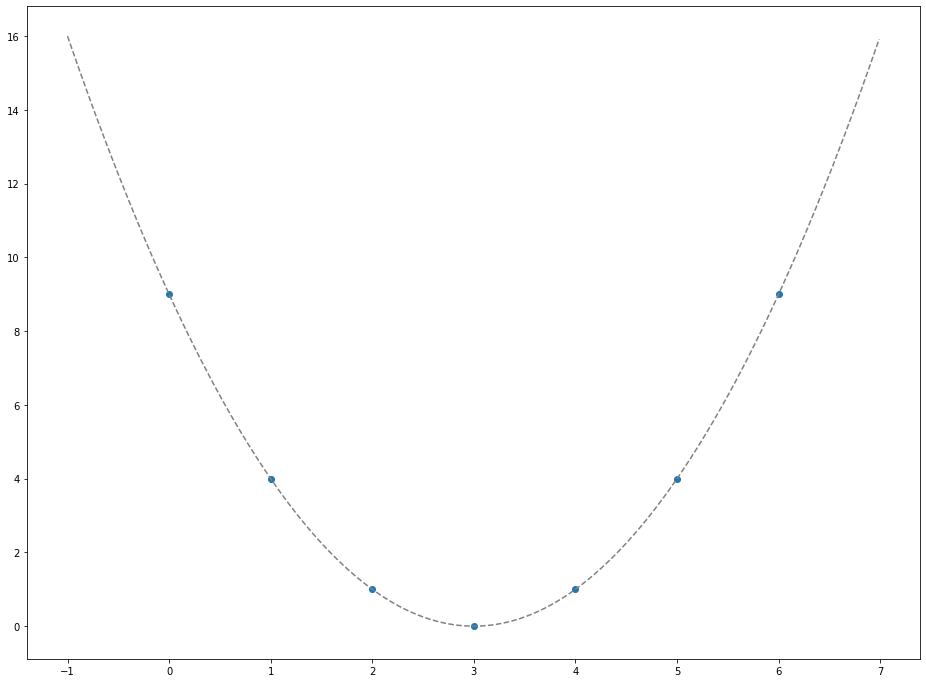

In [28]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2).astype('float64'), color='gray', linestyle='--')
plt.scatter(X_regr_toy, y_regr_toy)
plt.show()

In [40]:
boost_regr_mse = GradientBoostingCustom(n_estimators=200, loss='mse', max_depth=3,
                                 learning_rate=0.1, debug=True)

In [41]:
boost_regr_mse.fit(X_regr_toy, y_regr_toy)

GradientBoostingCustom(debug=True, learning_rate=0.1, loss=None, max_depth=3,
            n_estimators=200, random_state=17)

Налицо проблема деревьев &ndash; они не умеют экстраполировать, только интерполировать. В данном случае прогноз вне интервала [0, 6] будет константным.

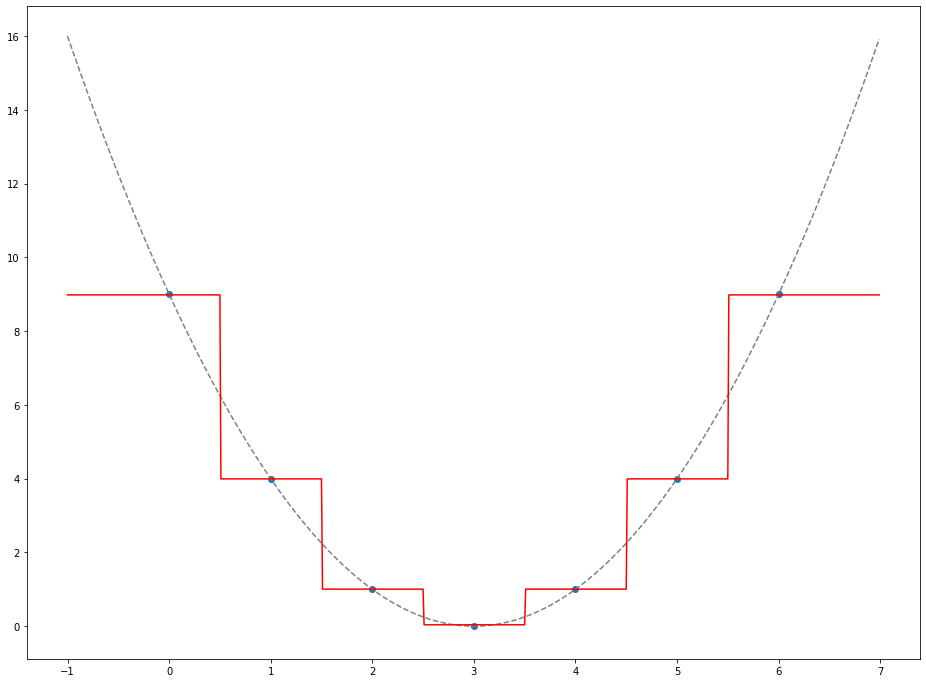

In [42]:
plt.plot(xx, ((xx - 3) ** 2).astype('float64'), color='gray', linestyle='--')
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, boost_regr_mse.predict(xx.reshape([xx.shape[0], 1])), color='red')
plt.show()

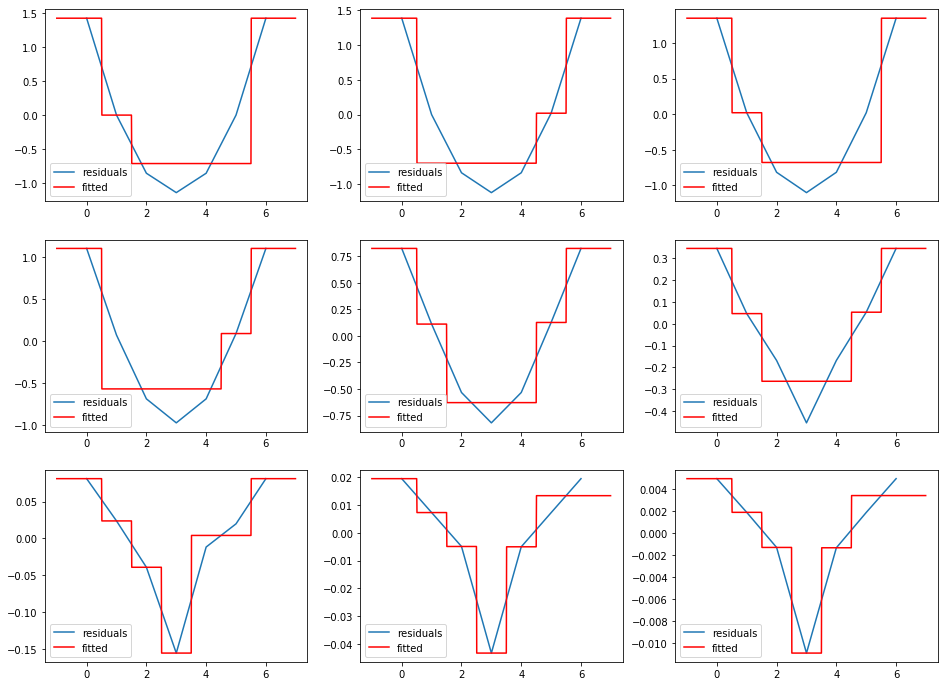

In [44]:
plt.rcParams['figure.figsize'] = (16, 12)

plt.subplots(3, 3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_mse.residuals[tree_idx - 1], label='residuals')
    plt.plot(xx, boost_regr_mse.trees[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
            color='red', label='fitted');
    plt.legend();

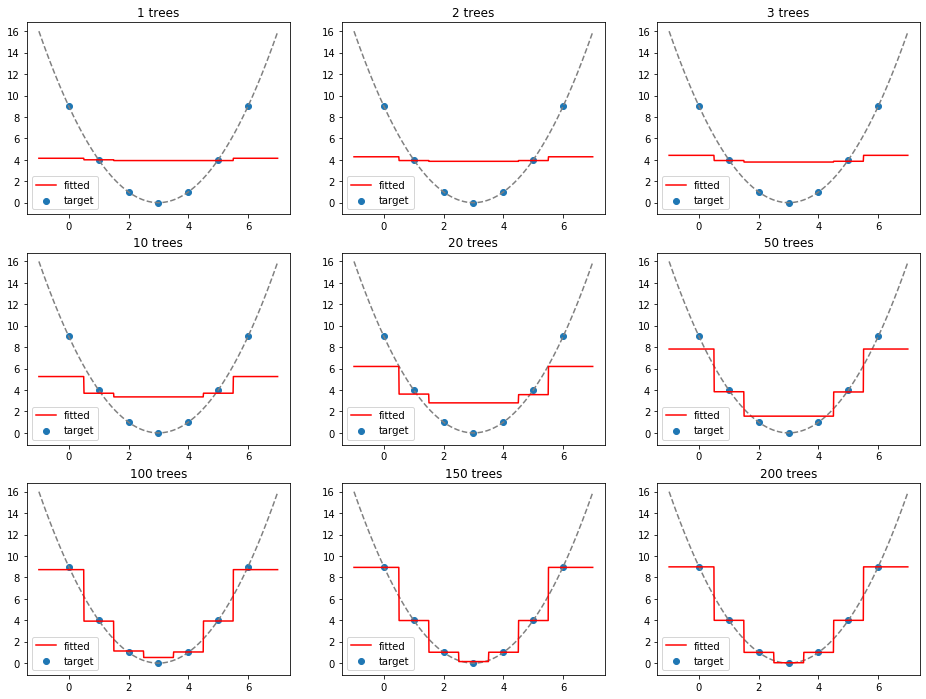

In [45]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    boost_regr_mse = GradientBoostingCustom(n_estimators=n_trees, loss='mse', max_depth=3,
                                 learning_rate=0.1, debug=True)
    boost_regr_mse.fit(X_regr_toy, y_regr_toy)
    
    plt.plot(xx, ((xx - 3) ** 2).astype('float64'), 
             color='gray', linestyle='--')
    plt.scatter(X_regr_toy, y_regr_toy, label='target')
    plt.plot(xx, boost_regr_mse.predict(xx.reshape([xx.shape[0], 1])),
            color='red', label='fitted');
    plt.legend();
    plt.title('%s trees' % str(n_trees))

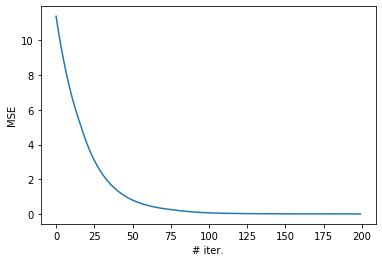

In [46]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(range(len(boost_regr_mse.loss_by_iter)), boost_regr_mse.loss_by_iter)
plt.xlabel('# iter.')
plt.ylabel('MSE')
plt.show()

## Проверка алгоритма на данных

In [56]:
data = pd.read_csv('task2.csv', names=['x1', 'x2', 'y'])
data.head()

,x1,x2,y
0,-0.379297,0.096971,1
1,0.172703,-0.464923,1
2,0.142410,-0.438775,1
3,0.414678,0.253156,1
4,0.270132,0.114764,1


In [57]:
data.isnull().sum()

x1    0
x2    0
y     0
dtype: int64

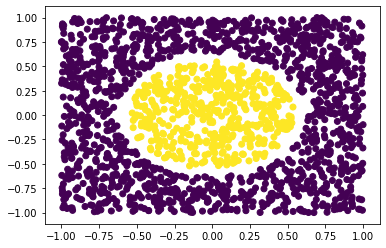

In [58]:
plt.scatter(data['x1'], data['x2'], c=data['y'])

In [59]:
X = data.drop(columns=['y'])
y = data['y']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1468, 2)
(367, 2)
(1468,)
(367,)


In [137]:
gbc = GradientBoostingCustom(n_estimators=400, loss='log_loss', max_depth=6,
                                 learning_rate=0.015, debug=True)
gbc.fit(X_train.values, y_train.values)

GradientBoostingCustom(debug=True, learning_rate=0.015, loss=None,
            max_depth=6, n_estimators=400, random_state=17)

In [187]:
gbc.predict(np.array([[0,0], [1,1]]))

array([[1],
       [0]])

In [197]:
y_test22 = np.array([1 if i==1 else 0 for i in y_test.values])

In [203]:
otv = gbc.predict(X_test)

In [205]:
accuracy = ((y_test2==otv.flatten())==True).sum() / y_test.shape[0]
accuracy 

0.9754768392370572

Получилось достичь accuracy = 0.975

## Выводы:

1.  Деревья не умеют экстраполировать, только интерполировать.
2. В задаче классификации достигнута accuracy = 0.975. Значит алгорит реализован правильно.